# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
%matplotlib inline

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

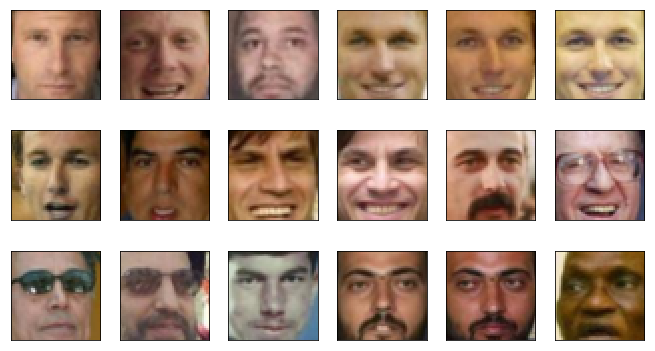

In [6]:
plot_gallery(X_train, image_h, image_w)

In [7]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [52]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.bias.data.fill_(0)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(6075, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, dimZ),
            nn.BatchNorm1d(dimZ),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 6075),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        latent_code = self.encoder(x) 
        reconstruction = self.decoder(latent_code)
           
        return reconstruction, latent_code

In [53]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()
autoencoder.apply(weight_init)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [54]:
def compute_loss(model, X_batch, y_batch, gpu=False):
    compute_grad=True
    if gpu:
        X_batch = torch.tensor(X_batch, requires_grad=compute_grad).cuda()
        y_batch = torch.tensor(y_batch).cuda()
    else:
        X_batch = torch.tensor(X_batch, requires_grad=compute_grad)
        y_batch = torch.tensor(y_batch)
    reconstruction, latent_code = model(X_batch)
    return F.mse_loss(reconstruction, y_batch), latent_code

In [55]:
def train_evaluate_model(model, train_loader, test_loader, gpu=False):
    num_epochs = 100 # total amount of full passes over training data
    batch_size = 100  # number of samples processed in one SGD iteration
    
    opt = torch.optim.Adam(model.parameters())

    train_loss = []
    val_loss = []
    train_reconstructions = []
    val_reconstructions = []
    
    for epoch in tqdm_notebook(range(num_epochs)):
        if epoch % 10 == 0:
            random_samples_ind = torch.randint(0, len(test_loader), (5,), dtype=torch.long)
            random_samples = test_loader.dataset[random_samples_ind]
            model_output = model(random_samples[0].cuda())
            print(model_output[0].size())
            for i in range(5):
                plot_gallery([random_samples[0][i].numpy(), model_output[0][i].detach().cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
            plt.show()
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
#         print(X_train.shape, y_train.shape)
        for X_batch, y_batch in train_loader:
            # train on batch
            loss, _ = compute_loss(model, X_batch, X_batch, gpu=gpu)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.item())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in test_loader:
            if gpu:
                y_pred, _ = model(torch.tensor(X_batch).cuda())
                cur_mse = F.mse_loss(y_pred, X_batch.cuda())
            else:
                y_pred, _ = model(torch.tensor(X_batch))
                cur_mse = F.mse_loss(y_pred, X_batch)
                        
            val_loss.append(cur_mse.item())
            
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(val_loss[-len(train_loader.dataset) // batch_size:])))
        print("  validation loss: \t\t\t{:.6f}".format(
            np.mean(val_loss[-len(test_loader.dataset) // batch_size :])))

torch.Size([5, 6075])


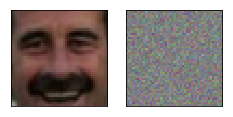

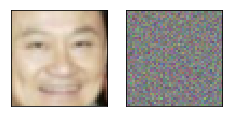

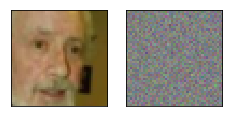

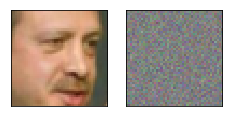

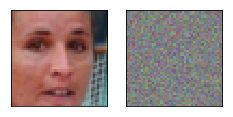

Epoch 1 of 100 took 2.861s
  training loss (in-iteration): 	0.007842
  validation loss: 			0.007580
Epoch 2 of 100 took 3.107s
  training loss (in-iteration): 	0.007853
  validation loss: 			0.006909
Epoch 3 of 100 took 2.908s
  training loss (in-iteration): 	0.005823
  validation loss: 			0.005585
Epoch 4 of 100 took 2.911s
  training loss (in-iteration): 	0.006287
  validation loss: 			0.006838
Epoch 5 of 100 took 2.918s
  training loss (in-iteration): 	0.005553
  validation loss: 			0.005222
Epoch 6 of 100 took 2.833s
  training loss (in-iteration): 	0.006523
  validation loss: 			0.006552
Epoch 7 of 100 took 2.838s
  training loss (in-iteration): 	0.005001
  validation loss: 			0.005238
Epoch 8 of 100 took 2.853s
  training loss (in-iteration): 	0.005679
  validation loss: 			0.005577
Epoch 9 of 100 took 2.855s
  training loss (in-iteration): 	0.004771
  validation loss: 			0.005050
Epoch 10 of 100 took 2.834s
  training loss (in-iteration): 	0.004282
  validation loss: 			0.004318

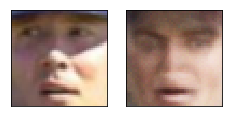

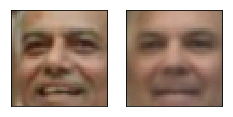

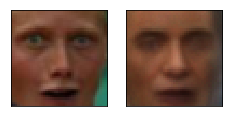

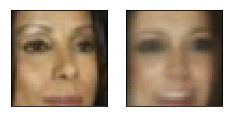

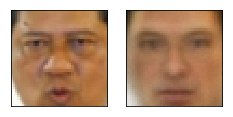

Epoch 11 of 100 took 2.881s
  training loss (in-iteration): 	0.004955
  validation loss: 			0.005165
Epoch 12 of 100 took 2.889s
  training loss (in-iteration): 	0.004341
  validation loss: 			0.003895
Epoch 13 of 100 took 2.849s
  training loss (in-iteration): 	0.003958
  validation loss: 			0.004132
Epoch 14 of 100 took 2.877s
  training loss (in-iteration): 	0.004116
  validation loss: 			0.003954
Epoch 15 of 100 took 2.854s
  training loss (in-iteration): 	0.004484
  validation loss: 			0.004748
Epoch 16 of 100 took 2.847s
  training loss (in-iteration): 	0.004180
  validation loss: 			0.004177
Epoch 17 of 100 took 2.916s
  training loss (in-iteration): 	0.003909
  validation loss: 			0.003510
Epoch 18 of 100 took 2.891s
  training loss (in-iteration): 	0.004654
  validation loss: 			0.004374
Epoch 19 of 100 took 2.891s
  training loss (in-iteration): 	0.004621
  validation loss: 			0.004555
Epoch 20 of 100 took 2.899s
  training loss (in-iteration): 	0.003545
  validation loss: 		

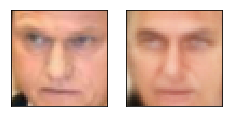

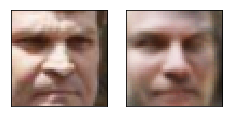

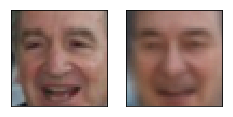

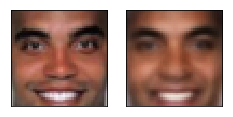

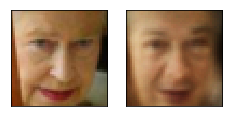

Epoch 21 of 100 took 3.094s
  training loss (in-iteration): 	0.003998
  validation loss: 			0.003865
Epoch 22 of 100 took 2.951s
  training loss (in-iteration): 	0.003442
  validation loss: 			0.003692
Epoch 23 of 100 took 2.906s
  training loss (in-iteration): 	0.003958
  validation loss: 			0.003750
Epoch 24 of 100 took 2.905s
  training loss (in-iteration): 	0.003700
  validation loss: 			0.003669
Epoch 25 of 100 took 2.912s
  training loss (in-iteration): 	0.004018
  validation loss: 			0.003703
Epoch 26 of 100 took 2.927s
  training loss (in-iteration): 	0.003337
  validation loss: 			0.003350
Epoch 27 of 100 took 2.883s
  training loss (in-iteration): 	0.004303
  validation loss: 			0.004104
Epoch 28 of 100 took 2.899s
  training loss (in-iteration): 	0.003241
  validation loss: 			0.003491
Epoch 29 of 100 took 2.922s
  training loss (in-iteration): 	0.003784
  validation loss: 			0.003567
Epoch 30 of 100 took 2.919s
  training loss (in-iteration): 	0.003931
  validation loss: 		

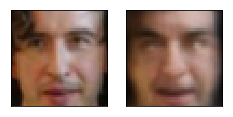

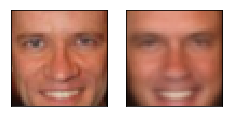

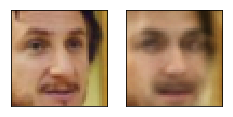

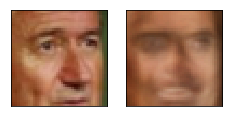

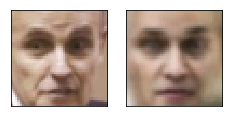

Epoch 31 of 100 took 2.873s
  training loss (in-iteration): 	0.003627
  validation loss: 			0.003801
Epoch 32 of 100 took 2.877s
  training loss (in-iteration): 	0.003206
  validation loss: 			0.003064
Epoch 33 of 100 took 2.859s
  training loss (in-iteration): 	0.003698
  validation loss: 			0.003393
Epoch 34 of 100 took 2.881s
  training loss (in-iteration): 	0.003594
  validation loss: 			0.003742
Epoch 35 of 100 took 2.853s
  training loss (in-iteration): 	0.003339
  validation loss: 			0.003399
Epoch 36 of 100 took 2.848s
  training loss (in-iteration): 	0.003555
  validation loss: 			0.003440
Epoch 37 of 100 took 2.887s
  training loss (in-iteration): 	0.003538
  validation loss: 			0.003667
Epoch 38 of 100 took 2.934s
  training loss (in-iteration): 	0.003826
  validation loss: 			0.003620
Epoch 39 of 100 took 2.890s
  training loss (in-iteration): 	0.003603
  validation loss: 			0.003782
Epoch 40 of 100 took 2.908s
  training loss (in-iteration): 	0.003143
  validation loss: 		

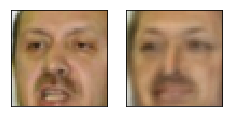

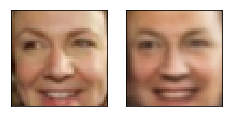

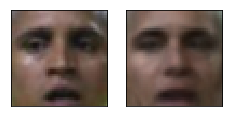

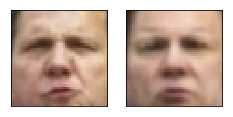

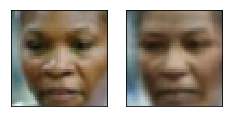

Epoch 41 of 100 took 2.844s
  training loss (in-iteration): 	0.003845
  validation loss: 			0.003826
Epoch 42 of 100 took 2.890s
  training loss (in-iteration): 	0.003163
  validation loss: 			0.003433
Epoch 43 of 100 took 2.957s
  training loss (in-iteration): 	0.003147
  validation loss: 			0.002960
Epoch 44 of 100 took 2.929s
  training loss (in-iteration): 	0.003322
  validation loss: 			0.003600
Epoch 45 of 100 took 2.927s
  training loss (in-iteration): 	0.003554
  validation loss: 			0.003726
Epoch 46 of 100 took 2.849s
  training loss (in-iteration): 	0.003035
  validation loss: 			0.002901
Epoch 47 of 100 took 2.865s
  training loss (in-iteration): 	0.003294
  validation loss: 			0.003342
Epoch 48 of 100 took 2.903s
  training loss (in-iteration): 	0.003415
  validation loss: 			0.002935
Epoch 49 of 100 took 2.955s
  training loss (in-iteration): 	0.005490
  validation loss: 			0.005189
Epoch 50 of 100 took 2.894s
  training loss (in-iteration): 	0.003241
  validation loss: 		

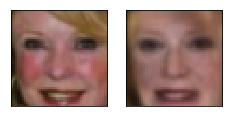

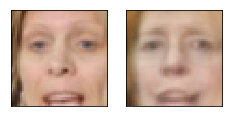

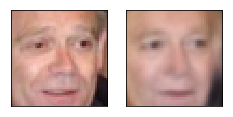

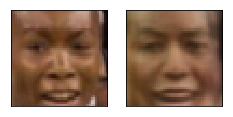

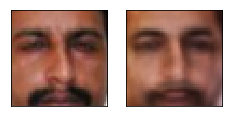

Epoch 51 of 100 took 2.898s
  training loss (in-iteration): 	0.003634
  validation loss: 			0.003276
Epoch 52 of 100 took 2.893s
  training loss (in-iteration): 	0.003431
  validation loss: 			0.003206
Epoch 53 of 100 took 2.854s
  training loss (in-iteration): 	0.003279
  validation loss: 			0.003285
Epoch 54 of 100 took 2.836s
  training loss (in-iteration): 	0.003625
  validation loss: 			0.003626
Epoch 55 of 100 took 2.837s
  training loss (in-iteration): 	0.003094
  validation loss: 			0.002999
Epoch 56 of 100 took 2.857s
  training loss (in-iteration): 	0.003204
  validation loss: 			0.003157
Epoch 57 of 100 took 2.872s
  training loss (in-iteration): 	0.003006
  validation loss: 			0.002806
Epoch 58 of 100 took 2.861s
  training loss (in-iteration): 	0.003735
  validation loss: 			0.003878
Epoch 59 of 100 took 2.861s
  training loss (in-iteration): 	0.003121
  validation loss: 			0.002904
Epoch 60 of 100 took 2.859s
  training loss (in-iteration): 	0.003424
  validation loss: 		

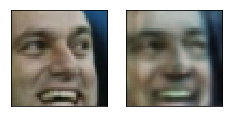

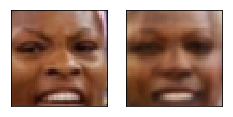

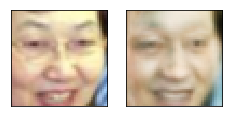

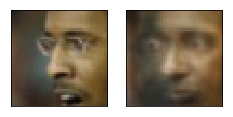

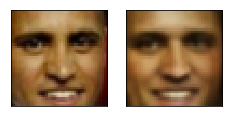

Epoch 61 of 100 took 2.879s
  training loss (in-iteration): 	0.003265
  validation loss: 			0.003228
Epoch 62 of 100 took 2.845s
  training loss (in-iteration): 	0.003354
  validation loss: 			0.003396
Epoch 63 of 100 took 2.846s
  training loss (in-iteration): 	0.002971
  validation loss: 			0.002896
Epoch 64 of 100 took 2.867s
  training loss (in-iteration): 	0.003233
  validation loss: 			0.003147
Epoch 65 of 100 took 2.834s
  training loss (in-iteration): 	0.003131
  validation loss: 			0.003369
Epoch 66 of 100 took 2.857s
  training loss (in-iteration): 	0.003239
  validation loss: 			0.003401
Epoch 67 of 100 took 2.883s
  training loss (in-iteration): 	0.003611
  validation loss: 			0.004230
Epoch 68 of 100 took 2.881s
  training loss (in-iteration): 	0.003166
  validation loss: 			0.003433
Epoch 69 of 100 took 2.886s
  training loss (in-iteration): 	0.003003
  validation loss: 			0.002746
Epoch 70 of 100 took 2.865s
  training loss (in-iteration): 	0.003204
  validation loss: 		

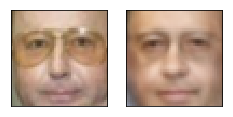

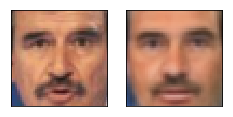

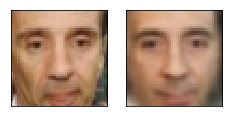

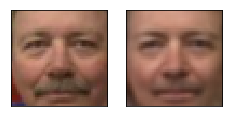

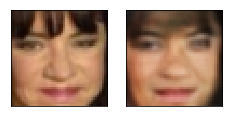

Epoch 71 of 100 took 3.193s
  training loss (in-iteration): 	0.003128
  validation loss: 			0.002810
Epoch 72 of 100 took 2.887s
  training loss (in-iteration): 	0.003476
  validation loss: 			0.003195
Epoch 73 of 100 took 3.068s
  training loss (in-iteration): 	0.003423
  validation loss: 			0.003564
Epoch 74 of 100 took 2.956s
  training loss (in-iteration): 	0.003022
  validation loss: 			0.003310
Epoch 75 of 100 took 2.924s
  training loss (in-iteration): 	0.003077
  validation loss: 			0.003372
Epoch 76 of 100 took 2.913s
  training loss (in-iteration): 	0.003627
  validation loss: 			0.003695
Epoch 77 of 100 took 2.882s
  training loss (in-iteration): 	0.002998
  validation loss: 			0.002923
Epoch 78 of 100 took 2.976s
  training loss (in-iteration): 	0.003687
  validation loss: 			0.003495
Epoch 79 of 100 took 2.918s
  training loss (in-iteration): 	0.002840
  validation loss: 			0.002824
Epoch 80 of 100 took 3.073s
  training loss (in-iteration): 	0.003170
  validation loss: 		

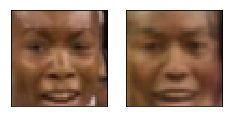

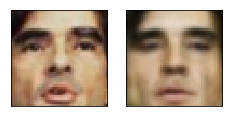

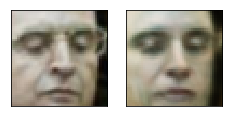

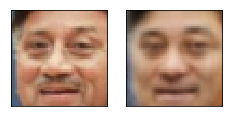

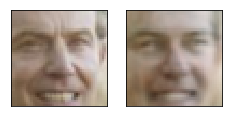

Epoch 81 of 100 took 3.068s
  training loss (in-iteration): 	0.003111
  validation loss: 			0.003509
Epoch 82 of 100 took 3.136s
  training loss (in-iteration): 	0.002948
  validation loss: 			0.002887
Epoch 83 of 100 took 3.142s
  training loss (in-iteration): 	0.003371
  validation loss: 			0.003658
Epoch 84 of 100 took 3.223s
  training loss (in-iteration): 	0.003166
  validation loss: 			0.003048
Epoch 85 of 100 took 3.043s
  training loss (in-iteration): 	0.002782
  validation loss: 			0.002878
Epoch 86 of 100 took 3.086s
  training loss (in-iteration): 	0.002822
  validation loss: 			0.002999
Epoch 87 of 100 took 3.250s
  training loss (in-iteration): 	0.003044
  validation loss: 			0.002724
Epoch 88 of 100 took 3.163s
  training loss (in-iteration): 	0.003199
  validation loss: 			0.003264
Epoch 89 of 100 took 3.076s
  training loss (in-iteration): 	0.003203
  validation loss: 			0.003240
Epoch 90 of 100 took 3.000s
  training loss (in-iteration): 	0.002890
  validation loss: 		

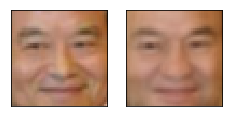

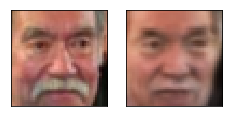

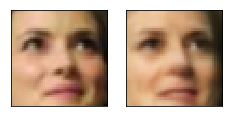

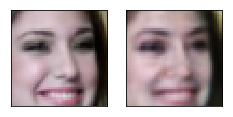

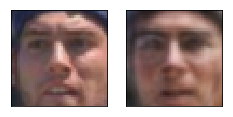

Epoch 91 of 100 took 2.858s
  training loss (in-iteration): 	0.003098
  validation loss: 			0.003116
Epoch 92 of 100 took 2.927s
  training loss (in-iteration): 	0.002741
  validation loss: 			0.002683
Epoch 93 of 100 took 2.902s
  training loss (in-iteration): 	0.003129
  validation loss: 			0.003013
Epoch 94 of 100 took 2.927s
  training loss (in-iteration): 	0.003116
  validation loss: 			0.003131
Epoch 95 of 100 took 3.017s
  training loss (in-iteration): 	0.002916
  validation loss: 			0.002768
Epoch 96 of 100 took 2.985s
  training loss (in-iteration): 	0.003110
  validation loss: 			0.002894
Epoch 97 of 100 took 2.969s
  training loss (in-iteration): 	0.003242
  validation loss: 			0.003405
Epoch 98 of 100 took 2.933s
  training loss (in-iteration): 	0.003045
  validation loss: 			0.003184
Epoch 99 of 100 took 2.900s
  training loss (in-iteration): 	0.003137
  validation loss: 			0.003158
Epoch 100 of 100 took 2.980s
  training loss (in-iteration): 	0.003112
  validation loss: 	

In [56]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
train_evaluate_model(autoencoder, train_loader, val_loader, gpu=True)

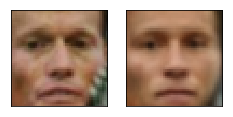

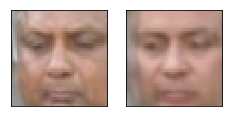

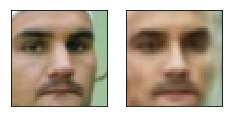

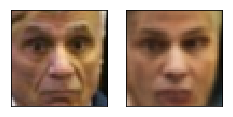

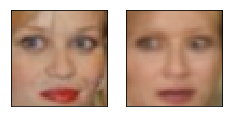

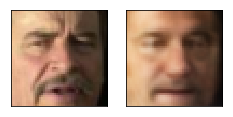

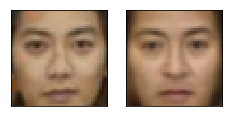

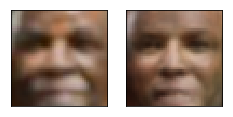

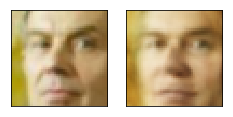

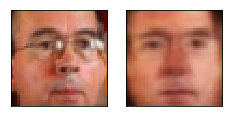

In [57]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0]).cuda()
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

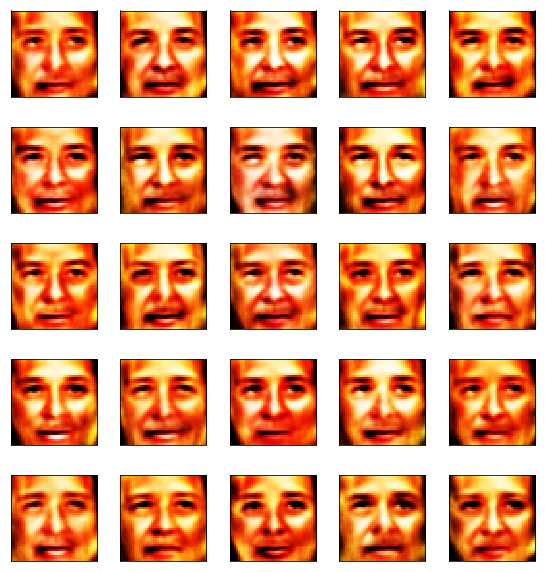

In [58]:
z = np.random.randn(25, dimZ)*0.5
output = autoencoder.decoder(torch.tensor(torch.from_numpy(z), dtype=torch.float).cuda())
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [18]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(6075, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2*dimZ))
        
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 6075 * 2)
        )
        self.s = nn.Sigmoid()
    def gaussian_sampler(self, mu, logsigma):
        #print(mu.size(), logsigma.size())
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        combined = self.encoder(x)
        return combined[:, :dimZ], combined[:, dimZ:]
        
    def decode(self, x):
        combined = self.decoder(x)
        return self.s(combined[:, :6075]), combined[:, 6075:]
        
    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        samples = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(samples)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma
        #TODO
        # return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [19]:
def KL_divergence(mu, logsigma):
    return -(dimZ + logsigma.sum(1) * 2 - (mu**2).sum(1) - (torch.exp(2*logsigma)).sum(1)) / 2

def log_likelihood(x, mu, logsigma):
    return -logsigma.sum(1) - ((mu - x)**2 / (2 * torch.exp(2*logsigma))).sum(1)

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    kl = KL_divergence(mu_z, logsigma_z)
    ll = log_likelihood(x, mu_gen, logsigma_gen)
#     print('kldiv', kl.mean())
   # print('loglike', ll)
    return (kl - ll).mean()

And train the model:

In [20]:
def train_evaluate_VAE(model, train_loader, test_loader, gpu=False):
    num_epochs = 100 # total amount of full passes over training data
    batch_size = 100  # number of samples processed in one SGD iteration
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_loss = []
    val_loss = []
    train_reconstructions = []
    val_reconstructions = []
    
    for epoch in tqdm_notebook(range(num_epochs)):
        if epoch % 10 == 0:
            random_samples_ind = torch.randint(0, len(test_loader), (5,), dtype=torch.long)
            random_samples = test_loader.dataset[random_samples_ind]
            model_output = model(random_samples[0].cuda())
            print(model_output[0].size())
            for i in range(5):
                plot_gallery([random_samples[0][i].numpy(), model_output[0][i].detach().cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
            plt.show()
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
#         print(X_train.shape, y_train.shape)
        for X_batch, y_batch in train_loader:
            # train on batch
            rm, rs, lm, ls = model(X_batch.cuda())
            #print(X_batch.size())
            #print(rm.size())
            loss = loss_vae(X_batch.cuda(), rm, rs, lm, ls)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.item())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in test_loader:
            if gpu:
                param = model(torch.tensor(X_batch).cuda())
                cur_mse = loss_vae(X_batch.cuda(), *param)
            else:
                param = model(torch.tensor(X_batch))
                cur_mse = loss_vae(X_batch, *param)
                        
            val_loss.append(cur_mse.item())
            
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(val_loss[-len(train_loader.dataset) // batch_size:])))
        print("  validation loss: \t\t\t{:.6f}".format(
            np.mean(val_loss[-len(test_loader.dataset) // batch_size :])))

In [21]:
vae = VAE().cuda()

torch.Size([5, 6075])


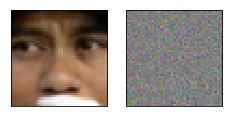

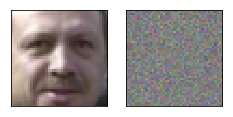

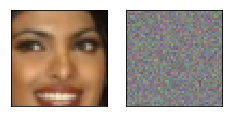

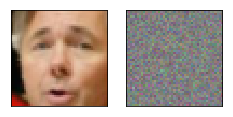

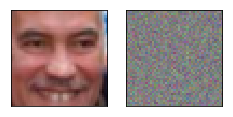

Epoch 1 of 100 took 5.039s
  training loss (in-iteration): 	-7643.063750
  validation loss: 			-7638.018936
Epoch 2 of 100 took 4.960s
  training loss (in-iteration): 	-10060.980127
  validation loss: 			-9706.202911
Epoch 3 of 100 took 4.898s
  training loss (in-iteration): 	-10545.606157
  validation loss: 			-10338.843414
Epoch 4 of 100 took 4.967s
  training loss (in-iteration): 	-11231.969287
  validation loss: 			-11022.166229
Epoch 5 of 100 took 4.878s
  training loss (in-iteration): 	-11150.039155
  validation loss: 			-10986.746429
Epoch 6 of 100 took 4.879s
  training loss (in-iteration): 	-11712.760537
  validation loss: 			-11470.879852
Epoch 7 of 100 took 4.866s
  training loss (in-iteration): 	-11967.584824
  validation loss: 			-11806.233704
Epoch 8 of 100 took 4.984s
  training loss (in-iteration): 	-11718.146211
  validation loss: 			-11558.282349
Epoch 9 of 100 took 5.057s
  training loss (in-iteration): 	-11104.170234
  validation loss: 			-10972.779846
Epoch 10 of 1

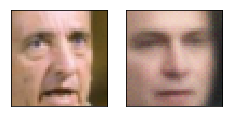

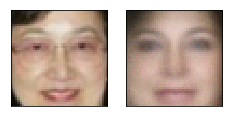

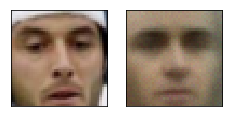

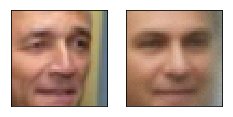

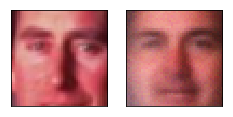

Epoch 11 of 100 took 5.105s
  training loss (in-iteration): 	-12087.739687
  validation loss: 			-12007.759277
Epoch 12 of 100 took 5.109s
  training loss (in-iteration): 	-12393.102686
  validation loss: 			-12264.960510
Epoch 13 of 100 took 5.030s
  training loss (in-iteration): 	-12327.116333
  validation loss: 			-12249.872803
Epoch 14 of 100 took 5.054s
  training loss (in-iteration): 	-12157.618496
  validation loss: 			-12060.424255
Epoch 15 of 100 took 4.843s
  training loss (in-iteration): 	-12583.600405
  validation loss: 			-12468.591278
Epoch 16 of 100 took 4.817s
  training loss (in-iteration): 	-12635.672236
  validation loss: 			-12577.176544
Epoch 17 of 100 took 4.899s
  training loss (in-iteration): 	-12596.143687
  validation loss: 			-12533.607391
Epoch 18 of 100 took 4.886s
  training loss (in-iteration): 	-12581.766279
  validation loss: 			-12465.181122
Epoch 19 of 100 took 4.900s
  training loss (in-iteration): 	-12586.391660
  validation loss: 			-12532.608276
E

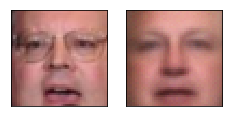

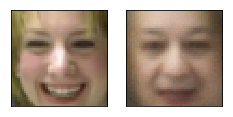

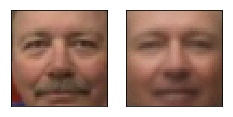

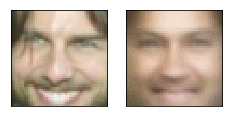

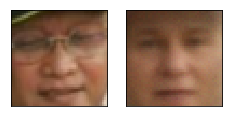

Epoch 21 of 100 took 5.256s
  training loss (in-iteration): 	-12372.688491
  validation loss: 			-12361.431732
Epoch 22 of 100 took 5.160s
  training loss (in-iteration): 	-12575.794517
  validation loss: 			-12555.356842
Epoch 23 of 100 took 5.105s
  training loss (in-iteration): 	-12782.210352
  validation loss: 			-12707.725952
Epoch 24 of 100 took 4.958s
  training loss (in-iteration): 	-12984.206201
  validation loss: 			-12886.728882
Epoch 25 of 100 took 4.944s
  training loss (in-iteration): 	-12790.999189
  validation loss: 			-12688.048248
Epoch 26 of 100 took 4.965s
  training loss (in-iteration): 	-12456.398008
  validation loss: 			-12411.810760
Epoch 27 of 100 took 5.086s
  training loss (in-iteration): 	-12944.428018
  validation loss: 			-12856.701630
Epoch 28 of 100 took 4.932s
  training loss (in-iteration): 	-12928.677432
  validation loss: 			-12890.689880
Epoch 29 of 100 took 5.071s
  training loss (in-iteration): 	-12556.741455
  validation loss: 			-12488.224670
E

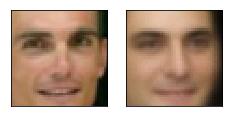

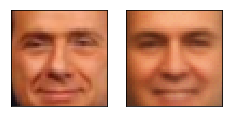

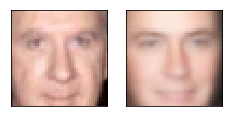

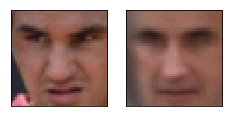

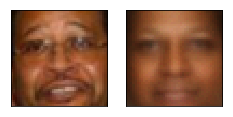

Epoch 31 of 100 took 4.938s
  training loss (in-iteration): 	-12958.294302
  validation loss: 			-12938.603546
Epoch 32 of 100 took 4.967s
  training loss (in-iteration): 	-13173.141514
  validation loss: 			-13144.164581
Epoch 33 of 100 took 4.947s
  training loss (in-iteration): 	-13263.670171
  validation loss: 			-13172.956604
Epoch 34 of 100 took 5.030s
  training loss (in-iteration): 	-13166.638145
  validation loss: 			-13091.478149
Epoch 35 of 100 took 4.954s
  training loss (in-iteration): 	-12406.141724
  validation loss: 			-12369.116791
Epoch 36 of 100 took 4.905s
  training loss (in-iteration): 	-12965.065391
  validation loss: 			-12924.630249
Epoch 37 of 100 took 4.956s
  training loss (in-iteration): 	-13334.472661
  validation loss: 			-13277.776337
Epoch 38 of 100 took 4.957s
  training loss (in-iteration): 	-13003.546167
  validation loss: 			-12997.646637
Epoch 39 of 100 took 4.854s
  training loss (in-iteration): 	-12939.263984
  validation loss: 			-12928.675171
E

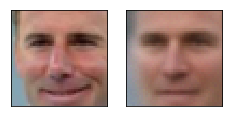

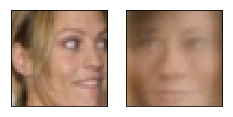

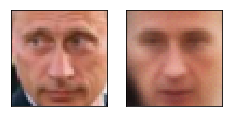

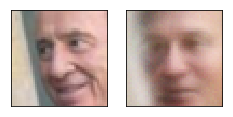

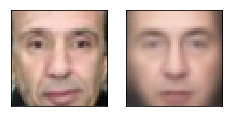

Epoch 41 of 100 took 4.872s
  training loss (in-iteration): 	-13020.475771
  validation loss: 			-12934.629456
Epoch 42 of 100 took 4.864s
  training loss (in-iteration): 	-13277.029961
  validation loss: 			-13189.826538
Epoch 43 of 100 took 4.828s
  training loss (in-iteration): 	-12794.831406
  validation loss: 			-12785.494598
Epoch 44 of 100 took 4.822s
  training loss (in-iteration): 	-13303.242295
  validation loss: 			-13240.938904
Epoch 45 of 100 took 4.856s
  training loss (in-iteration): 	-12884.331870
  validation loss: 			-12802.764709
Epoch 46 of 100 took 4.834s
  training loss (in-iteration): 	-13140.371611
  validation loss: 			-13122.886505
Epoch 47 of 100 took 4.855s
  training loss (in-iteration): 	-13513.874033
  validation loss: 			-13434.244781
Epoch 48 of 100 took 4.840s
  training loss (in-iteration): 	-13459.835615
  validation loss: 			-13436.859436
Epoch 49 of 100 took 4.856s
  training loss (in-iteration): 	-13509.726279
  validation loss: 			-13435.799255
E

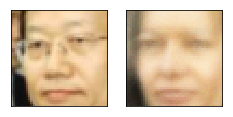

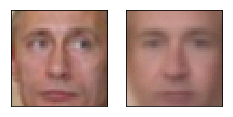

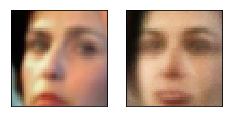

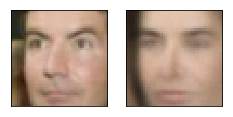

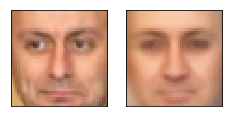

Epoch 51 of 100 took 4.911s
  training loss (in-iteration): 	-13611.235869
  validation loss: 			-13554.625793
Epoch 52 of 100 took 4.872s
  training loss (in-iteration): 	-13230.290146
  validation loss: 			-13248.097900
Epoch 53 of 100 took 4.871s
  training loss (in-iteration): 	-13292.691289
  validation loss: 			-13288.739319
Epoch 54 of 100 took 5.159s
  training loss (in-iteration): 	-13167.524912
  validation loss: 			-13087.783752
Epoch 55 of 100 took 4.888s
  training loss (in-iteration): 	-13472.825171
  validation loss: 			-13470.207153
Epoch 56 of 100 took 4.856s
  training loss (in-iteration): 	-13354.834209
  validation loss: 			-13277.226349
Epoch 57 of 100 took 4.858s
  training loss (in-iteration): 	-13444.954697
  validation loss: 			-13394.849396
Epoch 58 of 100 took 4.870s
  training loss (in-iteration): 	-13257.938486
  validation loss: 			-13218.928925
Epoch 59 of 100 took 5.008s
  training loss (in-iteration): 	-13566.224414
  validation loss: 			-13546.893311
E

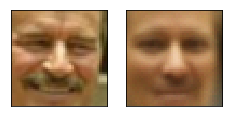

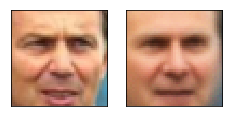

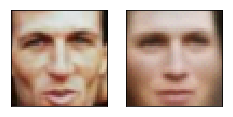

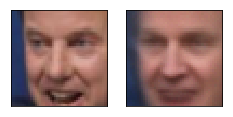

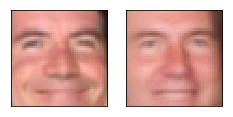

Epoch 61 of 100 took 4.978s
  training loss (in-iteration): 	-13579.737051
  validation loss: 			-13531.557556
Epoch 62 of 100 took 4.919s
  training loss (in-iteration): 	-13345.775381
  validation loss: 			-13351.063141
Epoch 63 of 100 took 4.931s
  training loss (in-iteration): 	-13514.833730
  validation loss: 			-13500.784210
Epoch 64 of 100 took 4.904s
  training loss (in-iteration): 	-13367.313076
  validation loss: 			-13326.787476
Epoch 65 of 100 took 4.968s
  training loss (in-iteration): 	-13383.188457
  validation loss: 			-13274.221741
Epoch 66 of 100 took 4.830s
  training loss (in-iteration): 	-13550.032632
  validation loss: 			-13597.123474
Epoch 67 of 100 took 4.848s
  training loss (in-iteration): 	-13377.640293
  validation loss: 			-13319.097534
Epoch 68 of 100 took 5.025s
  training loss (in-iteration): 	-13445.804834
  validation loss: 			-13383.314056
Epoch 69 of 100 took 4.972s
  training loss (in-iteration): 	-13331.149160
  validation loss: 			-13300.608704
E

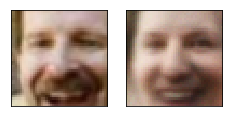

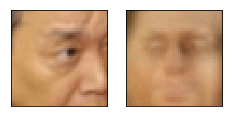

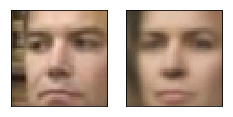

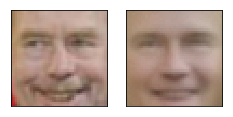

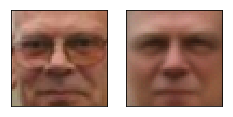

Epoch 71 of 100 took 4.848s
  training loss (in-iteration): 	-13596.718691
  validation loss: 			-13581.109589
Epoch 72 of 100 took 4.893s
  training loss (in-iteration): 	-13611.885723
  validation loss: 			-13626.244293
Epoch 73 of 100 took 4.890s
  training loss (in-iteration): 	-13087.378223
  validation loss: 			-13109.462769
Epoch 74 of 100 took 4.875s
  training loss (in-iteration): 	-13448.083887
  validation loss: 			-13415.246185
Epoch 75 of 100 took 4.892s
  training loss (in-iteration): 	-13507.969248
  validation loss: 			-13502.815094
Epoch 76 of 100 took 4.871s
  training loss (in-iteration): 	-13711.065693
  validation loss: 			-13709.259796
Epoch 77 of 100 took 4.893s
  training loss (in-iteration): 	-13586.155986
  validation loss: 			-13524.486450
Epoch 78 of 100 took 4.851s
  training loss (in-iteration): 	-13531.199355
  validation loss: 			-13495.875763
Epoch 79 of 100 took 4.856s
  training loss (in-iteration): 	-13523.482090
  validation loss: 			-13484.357697
E

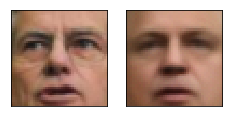

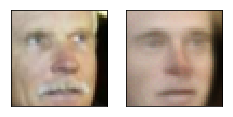

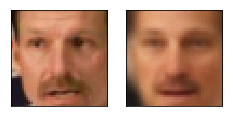

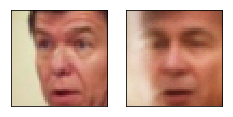

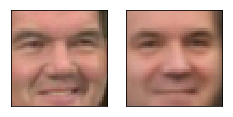

Epoch 81 of 100 took 4.897s
  training loss (in-iteration): 	-13685.545518
  validation loss: 			-13682.133392
Epoch 82 of 100 took 4.883s
  training loss (in-iteration): 	-13491.366699
  validation loss: 			-13437.906006
Epoch 83 of 100 took 4.859s
  training loss (in-iteration): 	-13787.818809
  validation loss: 			-13815.761322
Epoch 84 of 100 took 4.860s
  training loss (in-iteration): 	-13632.894165
  validation loss: 			-13625.906677
Epoch 85 of 100 took 4.843s
  training loss (in-iteration): 	-13242.380122
  validation loss: 			-13362.882080
Epoch 86 of 100 took 4.853s
  training loss (in-iteration): 	-13359.781172
  validation loss: 			-13378.276733
Epoch 87 of 100 took 4.815s
  training loss (in-iteration): 	-13731.684512
  validation loss: 			-13683.472748
Epoch 88 of 100 took 4.872s
  training loss (in-iteration): 	-13696.637285
  validation loss: 			-13703.303955
Epoch 89 of 100 took 4.890s
  training loss (in-iteration): 	-13606.811616
  validation loss: 			-13566.184814
E

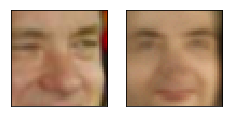

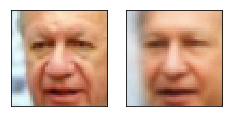

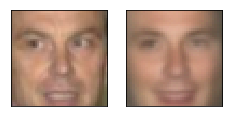

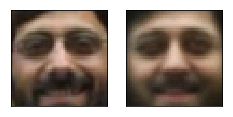

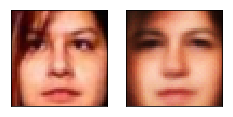

Epoch 91 of 100 took 4.884s
  training loss (in-iteration): 	-13693.268506
  validation loss: 			-13757.559845
Epoch 92 of 100 took 4.884s
  training loss (in-iteration): 	-13114.379961
  validation loss: 			-13144.748016
Epoch 93 of 100 took 4.883s
  training loss (in-iteration): 	-13611.781309
  validation loss: 			-13643.167450
Epoch 94 of 100 took 4.896s
  training loss (in-iteration): 	-13800.057539
  validation loss: 			-13806.732788
Epoch 95 of 100 took 5.025s
  training loss (in-iteration): 	-13425.995186
  validation loss: 			-13493.699829
Epoch 96 of 100 took 4.965s
  training loss (in-iteration): 	-13614.887583
  validation loss: 			-13667.676056
Epoch 97 of 100 took 4.997s
  training loss (in-iteration): 	-13470.963135
  validation loss: 			-13443.810455
Epoch 98 of 100 took 4.924s
  training loss (in-iteration): 	-13228.051514
  validation loss: 			-13400.069519
Epoch 99 of 100 took 4.859s
  training loss (in-iteration): 	-13664.166138
  validation loss: 			-13688.536713
E

In [22]:
# train your autoencoder
# visualize progress in reconstruction and loss decay
train_evaluate_VAE(vae, train_loader, val_loader, gpu=True)

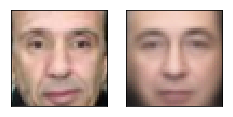

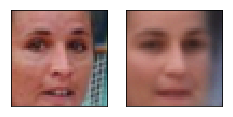

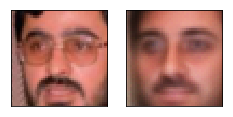

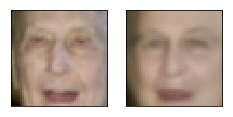

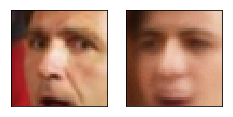

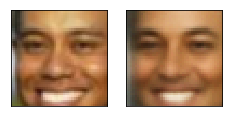

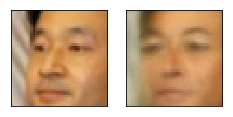

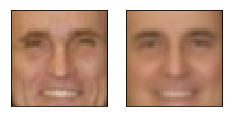

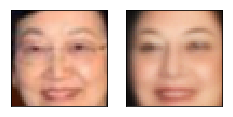

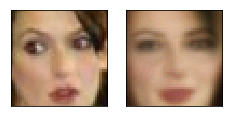

In [59]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda())
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

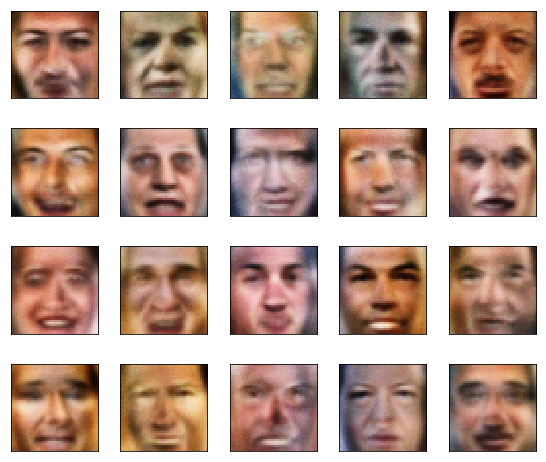

In [60]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
# Examine the reconstructions
# decoder_mu(z), z ~ N(0, 1)
samples = torch.randn(20, dimZ, requires_grad=True)
decoder_mu = vae.decode(samples.cuda())[0]
plot_gallery(decoder_mu.data.cpu().numpy(), image_h, image_w, n_row=4, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [71]:
sorted_index = attrs[:10000]['Smiling'].argsort()
non_smiling  = sorted_index[:10]
smiling = sorted_index[-10:]

samples = torch.randn(20, dimZ, requires_grad=True).cuda()

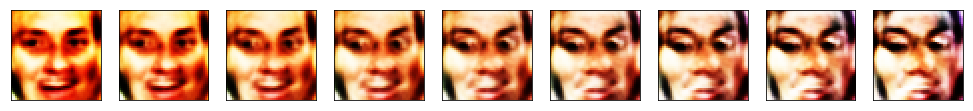

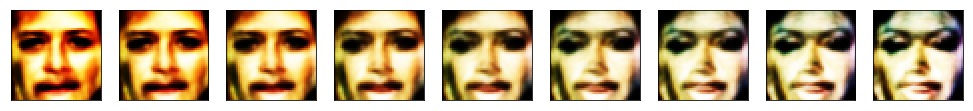

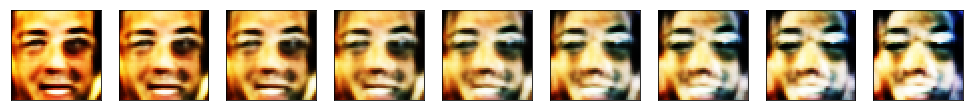

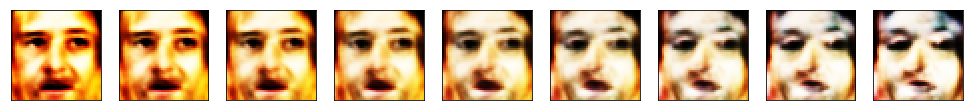

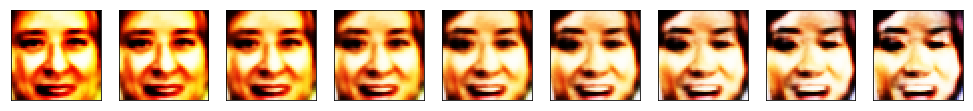

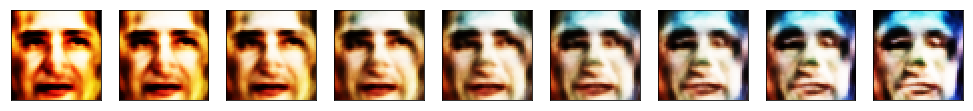

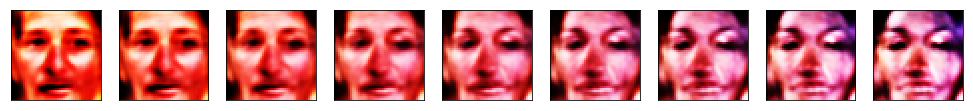

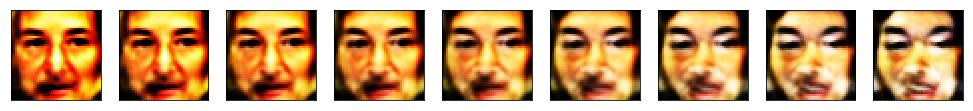

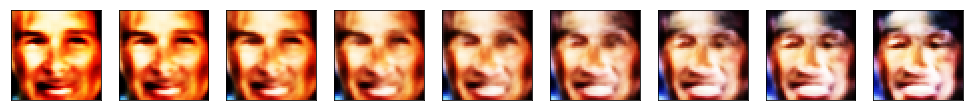

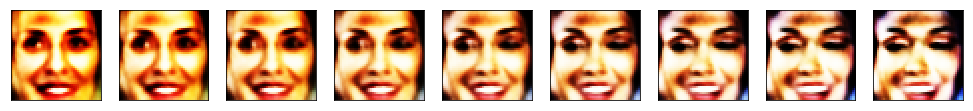

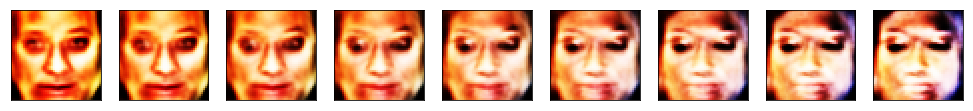

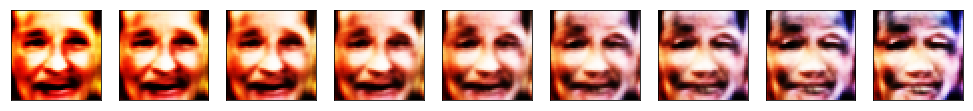

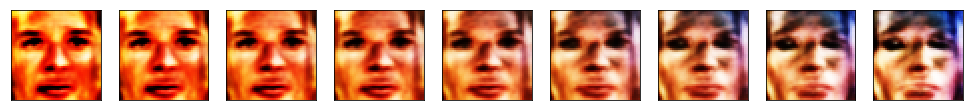

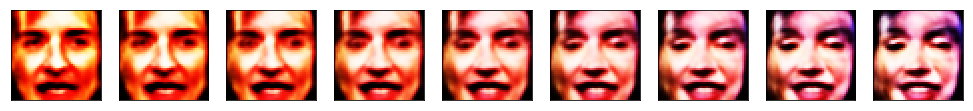

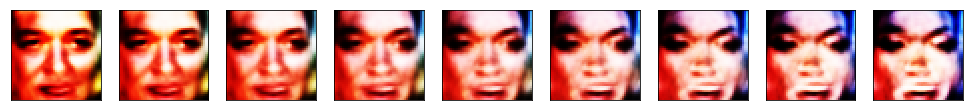

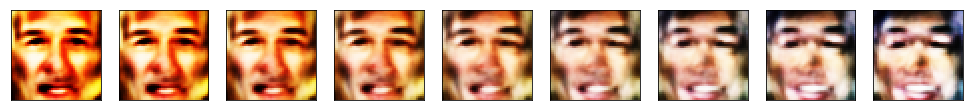

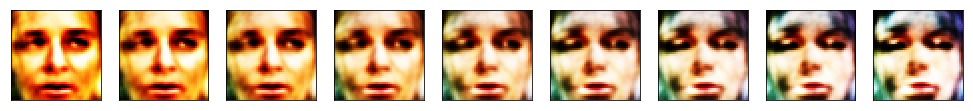

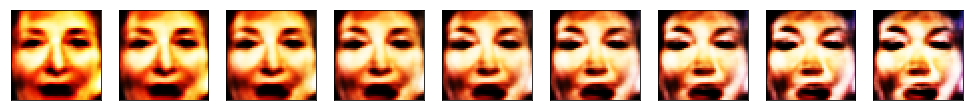

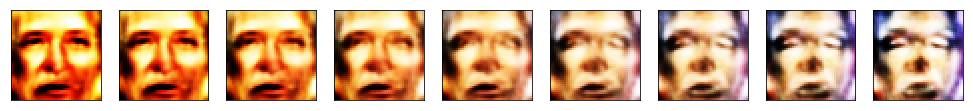

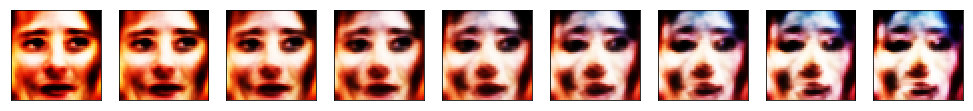

In [79]:
latent_smile = autoencoder.encoder(torch.from_numpy(X_train[smiling]).cuda())
latent_sadface = autoencoder.encoder(torch.from_numpy(X_train[non_smiling]).cuda())
latent_smile_avg = latent_smile.mean(0)
latent_sadface_avg = latent_sadface.mean(0)
difference = latent_smile_avg - latend_sadface_avg

for i in range(20):
    cur_sample = samples[i].view(1, -1)
    decoder_mu = autoencoder.decoder(cur_sample)
    images = [autoencoder.decoder(cur_sample + difference * coef).detach().cpu().numpy() for coef in np.linspace(0.1, 2, 9)]
    plot_gallery(images, image_h, image_w, n_row=1, n_col=9)

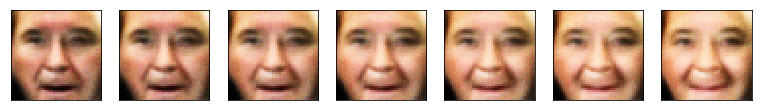

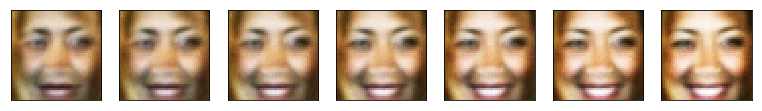

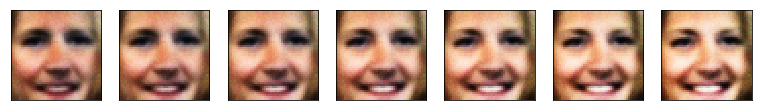

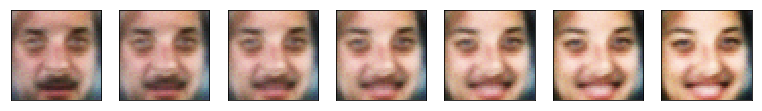

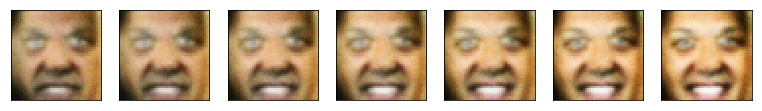

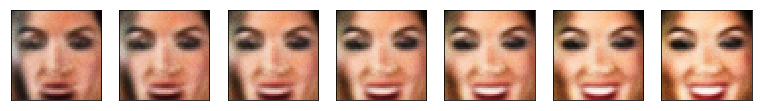

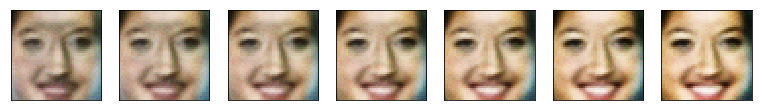

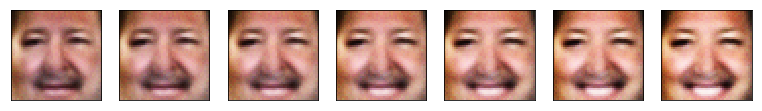

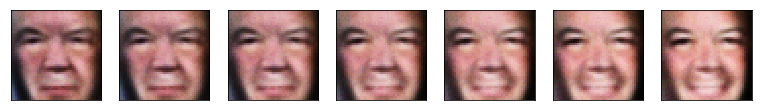

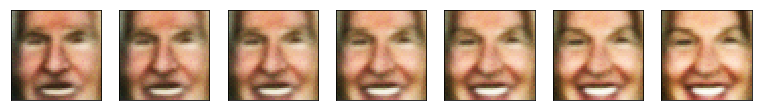

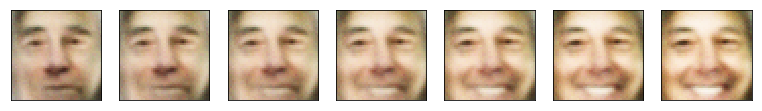

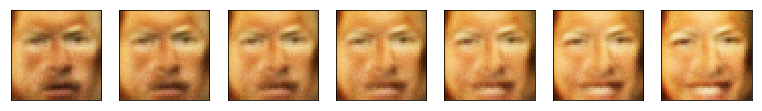

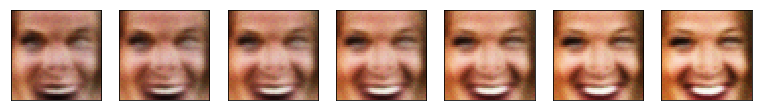

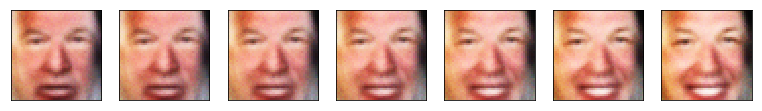

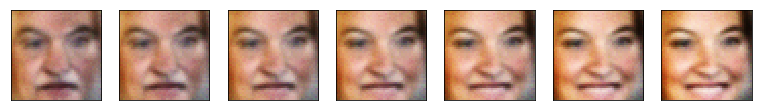

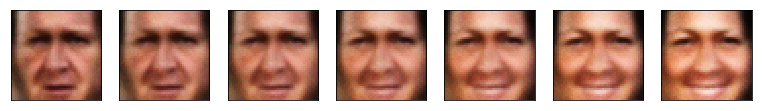

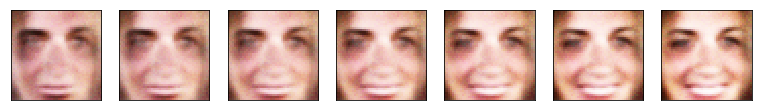

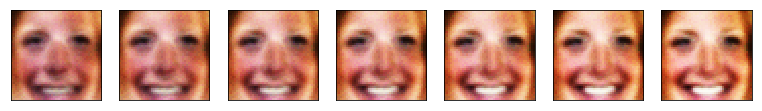

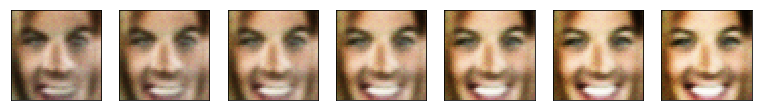

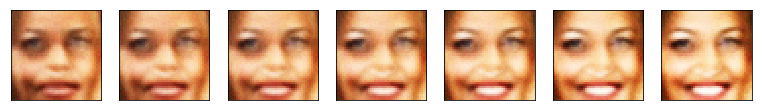

In [81]:
latent_smile, _ = vae.encode(torch.from_numpy(X_train[smiling]).cuda())
latent_sadface, _ = vae.encode(torch.from_numpy(X_train[non_smiling]).cuda())
latent_smile_avg = latent_smile.mean(0)
latent_sadface_avg = latent_sadface.mean(0)
difference = latent_smile_avg - latend_sadface_avg

for i in range(20):
    cur_sample = samples[i].view(1, -1)
    decoder_mu = vae.decode(cur_sample)[0]
    images = [vae.decode(cur_sample + difference * coef)[0].detach().cpu().numpy() for coef in np.linspace(0.1, 2, 7)]
    plot_gallery(images, image_h, image_w, n_row=1, n_col=7)

Looks like it works significantly better for VAE, compared to the usual autoencoder. Very cool

<img src="linear.png" alt="linear">